# Task 1 – The Dataset

All images are x-ray images taken in the chest region of children aged 1-5 from the
Guangzhou Women and Children’s Medical Center. There are 1100 images of healthy
humans, as well as 1100 images of people with pneumonia.
Keep in mind, that the image format is jpeg, and there are 3 color channels.
You need to organize the data into directories as shown on Figure 1. You need to determine
the training/validation/testing split yourselves but need to justify your split choice.

In [ ]:
import os
import shutil
import random
from math import floor
import matplotlib.pyplot as plt

In [ ]:
# Set the paths
source_dir = 'data/'
training_dir = 'data/training/'
validation_dir = 'data/validation/'
testing_dir = 'data/testing/'

# Create directories if they don't exist
os.makedirs(training_dir + 'normal', exist_ok=True)
os.makedirs(training_dir + 'pneumonia', exist_ok=True)
os.makedirs(validation_dir + 'normal', exist_ok=True)
os.makedirs(validation_dir + 'pneumonia', exist_ok=True)
os.makedirs(testing_dir + 'normal', exist_ok=True)
os.makedirs(testing_dir + 'pneumonia', exist_ok=True)

In [ ]:
# Gather files
normal_files = [f for f in os.listdir(source_dir) if '_normal' in f]
pneumonia_files = [f for f in os.listdir(source_dir) if '_pneumonia' in f]

# 75% for training, 15% for testing, 10% for validation
# keep majority of data for training to build a robust model
# but also allocate enough data for testing to evaluate performance and to prevent overfitting
def split_files(files, train_ratio=0.75, test_ratio=0.15):
    total_files = len(files)
    train_split = floor(total_files * train_ratio)
    test_split = floor(total_files * test_ratio)
    
    # shuffle the files to ensure randomness in the split
    random.shuffle(files)
    
    train_files = files[:train_split]
    test_files = files[train_split:train_split + test_split]
    val_files = files[train_split + test_split:]
    
    return train_files, test_files, val_files

# Split the files
normal_train, normal_test, normal_val = split_files(normal_files)
pneumonia_train, pneumonia_test, pneumonia_val = split_files(pneumonia_files)

In [ ]:
def move_files(files, dest_dir):
    for f in files:
        shutil.move(os.path.join(source_dir, f), os.path.join(dest_dir, f))

# Move normal files
move_files(normal_train, training_dir + 'normal/')
move_files(normal_test, testing_dir + 'normal/')
move_files(normal_val, validation_dir + 'normal/')

# Move pneumonia files
move_files(pneumonia_train, training_dir + 'pneumonia/')
move_files(pneumonia_test, testing_dir + 'pneumonia/')
move_files(pneumonia_val, validation_dir + 'pneumonia/')

print("Files have been successfully organized.")

Files have been successfully organized.


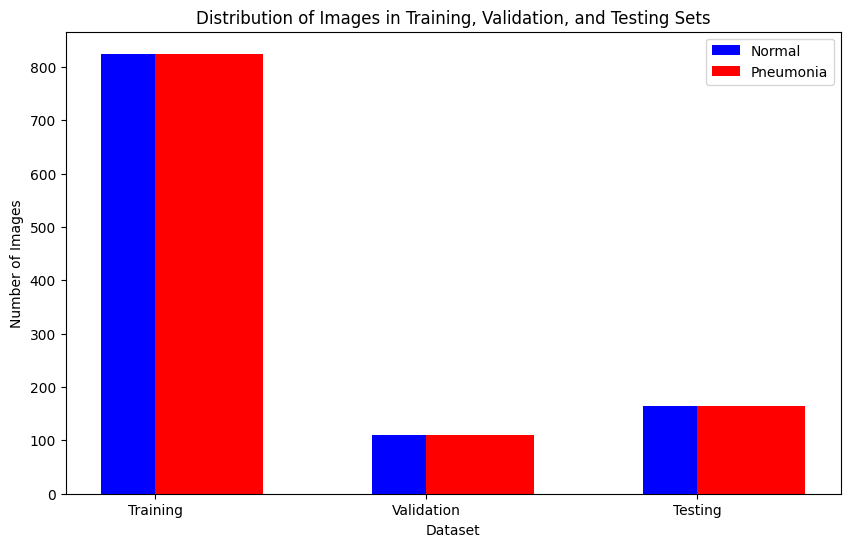

In [ ]:
# Function to count files in a directory
def count_files(directory):
    normal_count = len(os.listdir(os.path.join(directory, 'normal')))
    pneumonia_count = len(os.listdir(os.path.join(directory, 'pneumonia')))
    return normal_count, pneumonia_count

# Collect file counts
train_normal, train_pneumonia = count_files(training_dir)
val_normal, val_pneumonia = count_files(validation_dir)
test_normal, test_pneumonia = count_files(testing_dir)

# Prepare data for plotting
categories = ['Training', 'Validation', 'Testing']
normal_counts = [train_normal, val_normal, test_normal]
pneumonia_counts = [train_pneumonia, val_pneumonia, test_pneumonia]

# Plot the results
x = range(len(categories))

plt.figure(figsize=(10, 6))
plt.bar(x, normal_counts, width=0.4, label='Normal', color='blue', align='center')
plt.bar(x, pneumonia_counts, width=0.4, label='Pneumonia', color='red', align='edge')

plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Training, Validation, and Testing Sets')
plt.xticks(x, categories)
plt.legend()

# Display the plot
plt.show()

# Task 2 – Data Loading and Augmentation

We take the data from task 1, using the CustomDataset class we can load the data into the model, using torch DataLoader.
The data augmentation consists of a random horizontal flip, a random rotation up to 20 degrees and an affine transformation to make the model more robust for random patient oerientation. The randomaffine transform makes the model more robust. A scalejitter transformation makes the model more robust to images taken at different scales. Gaussian blur and noise make the model more robust to imperfect data.

In [18]:
import torch
import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

In [17]:
# define the global variables
input_dim=(256,256) # set the input dimension of the images to 256x256
channel_dim=1 # 1 for greyscale, 3 for RGB

In [16]:
# use the GPU if available to speed up the training (especially for google colab)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CPU


In [20]:
class CustomDataset(Dataset):
    def __init__(self, img_size, class_names, path=None, transformations=None, num_per_class: int = -1):
        self.img_size = img_size
        self.path = path
        self.num_per_class = num_per_class
        self.class_names = class_names
        self.transforms = transformations
        self.data = []
        self.labels = []

        if path:
            self.readImages()

        self.standard_transforms = transforms.Compose([
            transforms.ToTensor()
            ])

    def readImages(self):
        for id, class_name in self.class_names.items():
            print(f'Loading images from class: {id} : {class_name}')
            img_path = glob.glob(f'{self.path}{class_name}/*.jpg')
            if self.num_per_class > 0:
                img_path = img_path[:self.num_per_class]
            self.labels.extend([id] * len(img_path))
            for filename in img_path:
                img = Image.open(filename).convert('L')
                img = img.resize(self.img_size)
                self.data.append(img)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]

        if self.transforms:
            img = self.transforms(img)
        else:
            img = self.standard_transforms(img)

        label = torch.tensor(label, dtype=torch.long)

        return img, label

In [21]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_path = "data/training/"
test_path = "data/testing/"
validation_path = "data/validation/"

class_names = [name[len(train_path):] for name in glob.glob(f'{train_path}*')]
class_names = dict(zip(range(len(class_names)), class_names))

train_dataset = CustomDataset(img_size=input_dim, path=train_path, class_names=class_names, transformations=train_transform)
test_dataset = CustomDataset(img_size=input_dim, path=test_path, class_names=class_names)
validation_dataset = CustomDataset(img_size=input_dim, path=validation_path, class_names=class_names)

train_dataloader = DataLoader(train_dataset, shuffle=True)
test_dataloader = DataLoader(test_dataset, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, shuffle=True)

Loading images from class: 0 : pneumonia
Loading images from class: 1 : normal
Loading images from class: 0 : pneumonia
Loading images from class: 1 : normal
Loading images from class: 0 : pneumonia
Loading images from class: 1 : normal


# Task 3 – Construction the network

After successfully creating both the custom dataset and the dataloader, you need to create a
neural network, and use the data loader to feed the network. The architecture, complexity and
regularization are all up to you, but you need to justify your choices in comments. You are
more than welcome to replicate already known architectures or architectures we made during
the course, but you are NOT allowed to use any pretrained networks. You are also not
allowed to use any training data that is not included on ItsLearning.

Carefully consider which hyperparameters to test and strategically try to find the optimal
architecture for the task. In the comments, please describe your method for the optimization
and your choice of hyperparameters. Remember that there is an underlying competition, and
the highest accuracy wins. The competition will be measured based on the saved model, so
make sure to submit only the best one!

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

In [ ]:
class group_9(nn.Module):
    def __init__(self):
        super(group_9, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # Correct the input size for fc1 based on the calculations
        self.fc1 = nn.Linear(64 * 125*125, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.maxpool1(x)
        x = x.view(x.size(0), -1)

        # Fully Connected Layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return self.softmax(x)

In [ ]:
model = group_9()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

model.to(device)

group_9(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1000000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [ ]:
from tqdm.notebook import tqdm
pbar = None
def train(model, num_epochs: int = 3):
    for epoch in range(num_epochs):
        correct = 0
        total = 0
        model.train()

        pbar = tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch", leave=True)

        for data, targets in train_dataloader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            current_accuracy = correct / total * 100

            pbar.update(1)
            pbar.set_postfix(accuracy=f"{current_accuracy:.2f}%")

        pbar.close()
        tqdm.write(f"Epoch {epoch + 1}/{num_epochs}, Training accuracy: {current_accuracy:.2f}%")


        model.eval()
        correct_validation = 0
        total_validation = 0
        with torch.no_grad():
            for data, targets in validation_dataloader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total_validation += targets.size(0)
                correct_validation += (predicted == targets).sum().item()

        validation_accuracy = 100 * correct_validation / total_validation
        print(f'Validation accuracy: {validation_accuracy}%')
        torch.save(model.state_dict(), f'drive/MyDrive/SDU_Data/models/model_weights_3_{epoch}.pth')

In [ ]:
def test(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in test_dataloader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

In [ ]:
train(model=model, num_epochs=15)
test(model=model)

Epoch 1/15:   0%|          | 0/1740 [00:00<?, ?batch/s]

Epoch 1/15, Training accuracy: 53.05%
Validation accuracy: 50.0%


Epoch 2/15:   0%|          | 0/1740 [00:00<?, ?batch/s]

Epoch 2/15, Training accuracy: 58.97%
Validation accuracy: 90.9090909090909%


Epoch 3/15:   0%|          | 0/1740 [00:00<?, ?batch/s]

Epoch 3/15, Training accuracy: 77.59%
Validation accuracy: 91.81818181818181%


Epoch 4/15:   0%|          | 0/1740 [00:00<?, ?batch/s]

Epoch 4/15, Training accuracy: 87.41%
Validation accuracy: 92.72727272727273%


Epoch 5/15:   0%|          | 0/1740 [00:00<?, ?batch/s]

Epoch 5/15, Training accuracy: 88.45%
Validation accuracy: 94.0909090909091%


Epoch 6/15:   0%|          | 0/1740 [00:00<?, ?batch/s]

Epoch 6/15, Training accuracy: 90.23%
Validation accuracy: 75.0%


Epoch 7/15:   0%|          | 0/1740 [00:00<?, ?batch/s]

Epoch 7/15, Training accuracy: 89.37%
Validation accuracy: 94.0909090909091%


Epoch 8/15:   0%|          | 0/1740 [00:00<?, ?batch/s]

Epoch 8/15, Training accuracy: 92.24%
Validation accuracy: 94.0909090909091%


Epoch 9/15:   0%|          | 0/1740 [00:00<?, ?batch/s]

Epoch 9/15, Training accuracy: 91.90%
Validation accuracy: 95.0%


Epoch 10/15:   0%|          | 0/1740 [00:00<?, ?batch/s]

Epoch 10/15, Training accuracy: 92.70%
Validation accuracy: 92.72727272727273%


Epoch 11/15:   0%|          | 0/1740 [00:00<?, ?batch/s]

Epoch 11/15, Training accuracy: 93.51%
Validation accuracy: 93.63636363636364%


Epoch 12/15:   0%|          | 0/1740 [00:00<?, ?batch/s]

Epoch 12/15, Training accuracy: 93.74%
Validation accuracy: 95.45454545454545%


Epoch 13/15:   0%|          | 0/1740 [00:00<?, ?batch/s]

Epoch 13/15, Training accuracy: 94.02%
Validation accuracy: 95.45454545454545%


Epoch 14/15:   0%|          | 0/1740 [00:00<?, ?batch/s]

Epoch 14/15, Training accuracy: 94.20%
Validation accuracy: 92.72727272727273%


Epoch 15/15:   0%|          | 0/1740 [00:00<?, ?batch/s]

Epoch 15/15, Training accuracy: 95.29%
Validation accuracy: 95.45454545454545%
Test Accuracy: 92.73%


In [ ]:
torch.save(model.state_dict(), 'group_9.pth')

# Task 4 - Visualizing your results

Finally, you must visualize some aspects of your model. It can be a graph of the
training/validation performance, visualization of the filters or feature maps, or anything you
can think of. This must be saved as an image file and uploaded along with your model and
code.